In [167]:
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import geopandas as gpd
import xarray as xr
import time
import numpy as np
from scipy.stats import linregress
from scipy.interpolate import interp1d as int1
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
# Load EPU shapefile
LME = gpd.read_file('/Users/nyelab/Downloads/LME66/LMEs66.shp')

In [130]:
SEUS = LME[LME.LME_NUMBER  ==6]
SEUS_shape = SEUS.geometry[LME.OBJECTID[LME.LME_NUMBER == 6].values[0] -1]

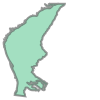

In [147]:
SEUS_shape = LME[LME.LME_NAME == 'Southeast U.S. Continental Shelf'].geometry[LME.OBJECTID[LME.LME_NUMBER == 6].values[0] -1]
SEUS_shape

In [100]:
bounds = SEUS.geometry.apply(lambda x: x.bounds).tolist()
bounds

[(-81.53388214095605,
  25.22859764075787,
  -74.9372482300733,
  35.210269927570266)]

In [129]:
LME.OBJECTID[LME.LME_NUMBER == 6].values[0] -1

18

In [51]:
#EPU[EPU.where(EPU.LME_NAME == 'Northeast U.S. Continental Shelf'),:]

NEUS = LME[LME.LME_NAME == 'Northeast U.S. Continental Shelf']
NEUS_shape = NEUS.geometry[11]

In [118]:
LME.OBJECTID[LME.LME_NAME == 'Northeast U.S. Continental Shelf'].values[0]

12

In [8]:
time.perf_counter()

40730.410939568

In [156]:
def inSHAPE_all_depth_glorys(longitude, latitude, var, depth, shape):
    x = longitude
    y = latitude
    empty = np.empty([28, len(depth), len(y), len(x)])
    empty[:,:,:,:] = np.nan
    for i in range(len(y)):
        for j in range(len(x)):
            if Point(x[j], y[i]).within(shape) == True:
                empty[:,:,i,j] = var[:,:,i,j]
    return empty

In [139]:
start = time.perf_counter()
start

90234.152413779

In [140]:
time1 = time.perf_counter()

In [144]:
'/Users/nyelab/Downloads/South Eastern United States Shelf/','cmems_mod_glo_phy_my_0.083_P1M-m_1658522346191.nc'
                                        ,'cmems_mod_glo_phy_my_0.083_P1M-m_1658522224326.nc', 'cmems_mod_glo_phy_my_0.083_P1M-m_1658522093028.nc',

0.15727263730004779

In [170]:
data1 = xr.open_dataset('/Users/nyelab/Downloads/South Eastern United States Shelf/cmems_mod_glo_phy_my_0.083_P1M-m_1658522346191.nc')

In [172]:
data1.latitude.max()

<xarray.DataArray 'latitude' ()>
array(35.5, dtype=float32)

In [176]:
def interpolate_5m(file, file_names1,file_names2,file_names3, LME_Name, LME):
    start = time.perf_counter()
    
    data1 = xr.open_dataset(file + file_names1)
    data2 = xr.open_dataset(file + file_names2)
    data3 = xr.open_dataset(file + file_names3)
    data = xr.merge([data1, data2, data3])
    
    time1 = time.perf_counter()
    print('Data download completed, '+ str((time1-start)/60) + ' minutes elapsed')
    
    datayr = data.groupby('time.year').mean('time')
    
    time2 = time.perf_counter()
    print('Yearly averaging completed, '+ str((time2-start)/60) + ' minutes elapsed')
    
    temp = inSHAPE_all_depth_glorys(datayr.longitude, datayr.latitude, datayr.thetao, datayr.depth,
                             LME[LME.LME_NAME == LME_Name].geometry[LME.OBJECTID[LME.LME_NAME == LME_Name].values[0] -1])
    
    time3 = time.perf_counter()
    print('Subsetting to LME area completed, '+ str((time3-start)/60) + ' minutes elapsed')
    
    z = np.arange(5,205,5)
    
    temp_5m = np.empty([28,len(z),len(datayr.latitude),len(datayr.longitude)])
    temp_5m[:,:,:,:] = np.nan
    for t in range(28):
        for i in range(len(datayr.latitude)):
            for j in range(len(datayr.longitude)):
                Y_data = temp[t,:,i,j]
                if np.any(Y_data)==True:
                    func = int1(datayr.depth,Y_data,bounds_error = False)
                    temp_5m[t,:,i,j] = func(z)
                    
    time4 = time.perf_counter()
    print('5m interpolation completed, '+ str((time2-start)/60) + ' minutes elapsed')
    
    temp5m = xr.Dataset(data_vars = {'temp': (['year','depth','lat','lon'],temp_5m)}, 
                    coords = {'year': datayr.year, 'depth': z, 'lat': np.array(datayr.latitude), 'lon': np.array(datayr.longitude)})
    return temp5m


In [116]:
test1 = vertical_climate_velocity('/Users/nyelab/Downloads/','cmems_mod_glo_phy_my_0.083_P1M-m_1654026641393.nc','cmems_mod_glo_phy_my_0.083_P1M-m_1654033932904.nc','cmems_mod_glo_phy_my_0.083_P1M-m_1654102088349.nc' ,'Northeast U.S. Continental Shelf'
                            )

TypeError: can only concatenate str (not "float") to str

In [177]:
SEUS_temp5m = interpolate_5m('/Users/nyelab/Downloads/South Eastern United States Shelf/','cmems_mod_glo_phy_my_0.083_P1M-m_1658942372240.nc'
                                        ,'cmems_mod_glo_phy_my_0.083_P1M-m_1658942290401.nc', 'cmems_mod_glo_phy_my_0.083_P1M-m_1658942123913.nc',
                                        'Southeast U.S. Continental Shelf', LME)

Data download completed, 0.10735000438338223 minutes elapsed
Yearly averaging completed, 0.11791335253340852 minutes elapsed
Subsetting to LME area completed, 0.23964067711664636 minutes elapsed
5m interpolation completed, 0.11791335253340852 minutes elapsed


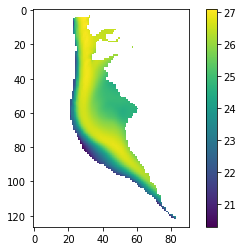

In [180]:
plt.imshow(SEUS_temp5m.temp[10,10,:,:])
plt.colorbar()

In [182]:
SEUS_temp5m

<xarray.Dataset>
Dimensions:  (depth: 40, lat: 127, lon: 91, year: 28)
Coordinates:
  * year     (year) int64 1993 1994 1995 1996 1997 ... 2016 2017 2018 2019 2020
  * depth    (depth) int64 5 10 15 20 25 30 35 ... 170 175 180 185 190 195 200
  * lat      (lat) float32 25.0 25.08 25.17 25.25 ... 35.25 35.33 35.42 35.5
  * lon      (lon) float32 -82.0 -81.92 -81.83 -81.75 ... -74.67 -74.58 -74.5
Data variables:
    temp     (year, depth, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [186]:
def temptrend(temp5m):
    
    start = time.perf_counter()
    
    slopes = np.empty([len(temp5m.lat),len(temp5m.lon),len(temp5m.depth)])
    p_vals = np.empty([len(temp5m.lat),len(temp5m.lon),len(temp5m.depth)])
    slopes[:,:,:] = np.nan
    p_vals[:,:,:] = np.nan

    x = np.arange(0,27)
    for i in range(len(temp5m.lat)):
        for j in range(len(temp5m.lon)):
            for k in range(len(temp5m.depth)):
                y = temp5m.temp[:27,k,i,j]
                if any(y) == True:
                    LR = linregress(x, y)
                    slopes[i,j,k] = LR.slope
                    p_vals[i,j,k] = LR.pvalue
                    
    time4 = time.perf_counter()
    
    print('Temperature Trends Complete, '+ str((time4-start)/60) + ' minutes elapsed')
    
    return slopes, p_vals

In [185]:
slopes_SEUS, pvals_SEUS = temptrend(SEUS_temp5m)

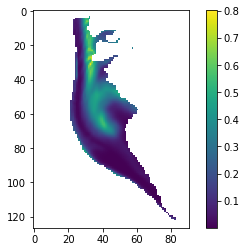

In [202]:
plt.imshow(pvals_SEUS[:,:,10
                     ])
plt.colorbar()

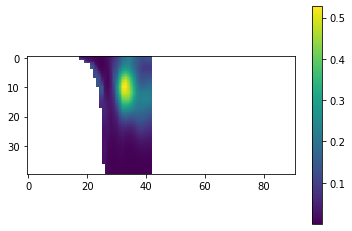

In [204]:
plt.imshow(pvals_SEUS[40,:,:].T)
plt.colorbar()
#plt.gca.invert_yaxis

In [207]:
def vertical_spat_grad(temp_data):
# Calculate the spatial gradient in the vertical
    start = time.perf_counter()
    
    UP = 5 # 5 meters between each data point
    DOWN = 5

    temp_slice_mean = np.nanmean(temp_data.temp[:,:,:,:],0)
    UD_net = np.empty([len(temp_data.depth),len(temp_data.lat),len(temp_data.lon)])
    UD_net[:,:,:] = np.nan

    for i in range(len(temp_data.depth)):
        for j in range(len(temp_data.lat)):
            for k in range(len(temp_data.lon)):
                if np.isnan(temp_slice_mean[i,j,k]) == False:
                    if i == 0: #at the surface
                        focal_temp = temp_slice_mean[i,j,k]
                        DO_grad = -1*(focal_temp - temp_slice_mean[i+1,j,k])/DOWN # angle = 0
                        UD_net[i,j,k] = DO_grad
                    if i == (len(temp_data.depth) -1): #at the bottom
                        focal_temp = temp_slice_mean[i,j,k]
                        UP_grad = (focal_temp - temp_slice_mean[i-1,j,k])/UP # angle = 180
                        UD_net[i,j,k] = UP_grad
                    if i >0 and i < (len(temp_data.depth)-1):
                        focal_temp = temp_slice_mean[i,j,k]
                        UP_grad = (focal_temp - temp_slice_mean[i-1,j,k])/UP # angle = 0
                        DO_grad = -1*((focal_temp - temp_slice_mean[i+1,j,k])/DOWN) # angle = 180
                        if np.isnan(UP_grad) == True and np.isnan(DO_grad) == True:
                            UD_net[i,j,k] = np.nan
                        else:
                            UD_net[i,j,k] = np.nansum([UP_grad, DO_grad])

    time4 = time.perf_counter()
    
    print('Vertical Spat Grad Complete, '+ str((time4-start)/60) + ' minutes elapsed')
    
    return UD_net

In [208]:
SEUS_SG = vertical_spat_grad(SEUS_temp5m)

<ipython-input-207-7c1e76c0921e>:8: RuntimeWarning: Mean of empty slice
  temp_slice_mean = np.nanmean(temp_data.temp[:,:,:,:],0)


Vertical Spat Grad Complete, 0.16166342438348996 minutes elapsed


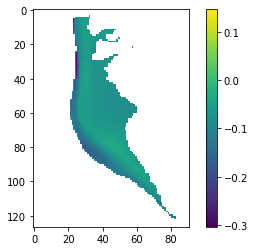

In [213]:
plt.imshow(SEUS_SG[10,:,:])
plt.colorbar()

In [13]:
glorys1 = xr.open_dataset('/Users/nyelab/Downloads/cmems_mod_glo_phy_my_0.083_P1M-m_1654026641393.nc')

In [14]:
glorys2 = xr.open_dataset('/Users/nyelab/Downloads/cmems_mod_glo_phy_my_0.083_P1M-m_1654033932904.nc')

In [15]:
glorys3 = xr.open_dataset('/Users/nyelab/Downloads/cmems_mod_glo_phy_my_0.083_P1M-m_1654102088349.nc')

In [16]:
# Merge the 2 datasets into one
glorys = xr.merge([glorys1,glorys2,glorys3])

In [155]:
glorys.depth[:27]


<xarray.DataArray 'depth' (depth: 27)>
array([  0.494025,   1.541375,   2.645669,   3.819495,   5.078224,   6.440614,
         7.92956 ,   9.572997,  11.405   ,  13.46714 ,  15.81007 ,  18.49556 ,
        21.59882 ,  25.21141 ,  29.44473 ,  34.43415 ,  40.34405 ,  47.37369 ,
        55.76429 ,  65.80727 ,  77.85385 ,  92.32607 , 109.7293  , 130.666   ,
       155.8507  , 186.1256  , 222.4752  ], dtype=float32)
Coordinates:
  * depth    (depth) float32 0.494 1.541 2.646 3.819 ... 130.7 155.9 186.1 222.5
Attributes:
    valid_min:               0.494025
    valid_max:               318.1274
    units:                   m
    positive:                down
    unit_long:               Meters
    long_name:               Depth
    standard_name:           depth
    axis:                    Z
    _ChunkSizes:             50
    _CoordinateAxisType:     Height
    _CoordinateZisPositive:  down

In [62]:
# Function for cropping data to EPU area
def inSHAPE_all_depth_glorys(longitude, latitude, var, shape):
    x = longitude
    y = latitude
    empty = np.empty([28, 29, 361, 301])
    empty[:,:,:,:] = np.nan
    for i in range(361):
        for j in range(301):
            if Point(x[j], y[i]).within(shape) == True:
                empty[:,:,i,j] = var[:,:,i,j]
    return empty

In [77]:
glorys.depth

<xarray.DataArray 'depth' (depth: 29)>
array([  0.494025,   1.541375,   2.645669,   3.819495,   5.078224,   6.440614,
         7.92956 ,   9.572997,  11.405   ,  13.46714 ,  15.81007 ,  18.49556 ,
        21.59882 ,  25.21141 ,  29.44473 ,  34.43415 ,  40.34405 ,  47.37369 ,
        55.76429 ,  65.80727 ,  77.85385 ,  92.32607 , 109.7293  , 130.666   ,
       155.8507  , 186.1256  , 222.4752  , 266.0403  , 318.1274  ],
      dtype=float32)
Coordinates:
  * depth    (depth) float32 0.494 1.541 2.646 3.819 ... 186.1 222.5 266.0 318.1
Attributes:
    valid_min:               0.494025
    valid_max:               318.1274
    units:                   m
    positive:                down
    unit_long:               Meters
    long_name:               Depth
    standard_name:           depth
    axis:                    Z
    _ChunkSizes:             50
    _CoordinateAxisType:     Height
    _CoordinateZisPositive:  down

In [64]:
a = time.perf_counter()
glorys_yr = glorys.groupby('time.year').mean('time')
b = time.perf_counter()
time1 = b-a
time1

20.48276937000628

In [65]:
a = time.perf_counter()
NEUStemp = inSHAPE_all_depth_glorys(glorys.longitude,glorys.latitude,glorys_yr.thetao,NEUS_shape)
b = time.perf_counter()
time2 = b-a
time2

52.7388114810019

In [78]:
# Interpolate variables to 5m vertical intervals in the upper 200m
a = time.perf_counter()
z = np.arange(5,205,5)
from scipy.interpolate import interp1d as int1
NEUStemp_5m = np.empty([28,len(z),361,301])
NEUStemp_5m[:,:,:,:] = np.nan
for t in range(28):
    for i in range(361):
        for j in range(301):
            Y_data = NEUStemp[t,:,i,j]
            if np.any(Y_data)==True:
                func = int1(glorys.depth,Y_data,bounds_error = False)
                NEUStemp_5m[t,:,i,j] = func(z)
    print(t)
b = time.perf_counter()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [175]:
glorys_yr

<xarray.Dataset>
Dimensions:    (depth: 29, latitude: 361, longitude: 301, year: 28)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 ... 222.5 266.0 318.1
  * latitude   (latitude) float32 20.0 20.08 20.17 20.25 ... 49.83 49.92 50.0
  * longitude  (longitude) float32 -85.0 -84.92 -84.83 ... -60.17 -60.08 -60.0
  * year       (year) int64 1993 1994 1995 1996 1997 ... 2017 2018 2019 2020
Data variables:
    thetao     (year, depth, latitude, longitude) float32 27.82 27.82 ... nan
    bottomT    (year, latitude, longitude) float32 3.635 3.635 ... 0.7368 0.7725

In [82]:
a = time.perf_counter()
slopesNEUS = np.empty([361,301,59])
p_valsNEUS = np.empty([361,301,59])
slopesNEUS[:,:,:] = np.nan
p_valsNEUS[:,:,:] = np.nan

x = np.arange(0,27)
for i in range(361):
    for j in range(301):
        for k in range(29):
            y = NEUStemp[:27,k,i,j]
            if any(y) == True:
                LR = linregress(x, y)
                slopesNEUS[i,j,k] = LR.slope
                p_valsNEUS[i,j,k] = LR.pvalue
    #print(i)
b = time.perf_counter()
time3 = b-a
time3

507.93733850800345

In [84]:
len(z)

40

In [89]:
a = time.perf_counter()
# Calculate the spatial gradient in the vertical
UP = 5 # 5 meters between each data point
DOWN = 5

NEUS_slice_mean = np.nanmean(NEUStemp_5m[:,:,:,:],0)
UD_netNEUS = np.empty([40,361,301])
UD_netNEUS[:,:,:] = np.nan

for i in range(40):
    for j in range(361):
        for k in range(301):
            if np.isnan(NEUS_slice_mean[i,j,k]) == False:
                if i == 0: #at the surface
                    focal_temp = NEUS_slice_mean[i,j,k]
                    DO_grad = -1*(focal_temp - NEUS_slice_mean[i+1,j,k])/DOWN # angle = 0
                    UD_netNEUS[i,j,k] = DO_grad
                if i == 39: #at the bottom
                    focal_temp = NEUS_slice_mean[i,j,k]
                    UP_grad = (focal_temp - NEUS_slice_mean[i-1,j,k])/UP # angle = 180
                    UD_netNEUS[i,j,k] = UP_grad
                if i >0 and i < 39:
                    focal_temp = NEUS_slice_mean[i,j,k]
                    UP_grad = (focal_temp - NEUS_slice_mean[i-1,j,k])/UP # angle = 0
                    DO_grad = -1*((focal_temp - NEUS_slice_mean[i+1,j,k])/DOWN) # angle = 180
                    if np.isnan(UP_grad) == True and np.isnan(DO_grad) == True:
                        UD_netNEUS[i,j,k] = np.nan
                    else:
                        UD_netNEUS[i,j,k] = np.nansum([UP_grad, DO_grad])
b = time.perf_counter()

time5 = b-a
time5

<ipython-input-89-b10a7a620fbe>:6: RuntimeWarning: Mean of empty slice
  NEUS_slice_mean = np.nanmean(NEUStemp_5m[:,:,:,:],0)


12.063238265000109

In [91]:
(time1+time2+time3+time4+time5)/60

21.809670853933493